<a href="https://colab.research.google.com/github/Migong0311/TIL/blob/october/1014/(%EC%8B%A4%EC%8A%B5_%EB%AC%B8%EC%A0%9C)_1_1_%EB%8D%B0%EC%9D%B4%ED%84%B0_EDA_%EB%B0%8F_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧠 머신러닝 기초 실습 정리 (with scikit-learn)

## 📍 1. 데이터 로딩 및 탐색적 데이터 분석 (EDA)

### ✅ 데이터 불러오기

```python
from sklearn.datasets import load_wine
import pandas as pd

df, y = load_wine(as_frame=True, return_X_y=True)
df["quality"] = y
```

### ✅ 데이터 개요

| 항목                     | 내용                        |
| ---------------------- | ------------------------- |
| 샘플 수 (`sample_count`)  | 178                       |
| 특성 수 (`feature_count`) | 14 (13 features + target) |
| 클래스 수 (`class_count`)  | 3 (0, 1, 2)               |

### ✅ 통계 및 분포

* `value_counts()` → 클래스별 개수 확인
* `groupby("quality")["alcohol"].mean()` → 알코올 평균 비교
* `df["malic_acid"].mean()`, `std()` → 평균/표준편차 계산
* 특정 조건 비율 예시:

  ```python
  (df["color_intensity"] >= 10).mean() * 100
  ```

---

## 📍 2. 시각화를 통한 데이터 탐색

### ✅ 상관관계 Heatmap

```python
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0)
plt.title("하삼각 상관계수 히트맵")
plt.show()
```

### ✅ 특성별 분포 탐색

```python
fig, ax = plt.subplots(figsize=(18, 5), ncols=3)

# 1️⃣ 세로형 히스토그램
sns.histplot(data=df, y="flavanoids", kde=True, color="steelblue", ax=ax[0])

# 2️⃣ 클래스별 히스토그램
sns.histplot(data=df, x="flavanoids", hue="quality", kde=True, element="step", palette="rocket", ax=ax[1])

# 3️⃣ 2D 히스토그램
sns.histplot(data=df, x="flavanoids", y="total_phenols", hue="quality", bins=20, palette="mako", ax=ax[2])
```

### ✅ 산점도

```python
sns.scatterplot(
    data=df, x="flavanoids", y="total_phenols",
    hue="quality", palette="rocket", s=60, edgecolor="none"
)
```

---

## 📍 3. sklearn을 통한 데이터 전처리

### ✅ Train/Test 분할 + 표준화

```python
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("quality", axis=1).values
y = df["quality"].values
y[y == 0] = 0
y[y != 0] = 1  # 이진 분류로 변환

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
```

---

## 📍 4. sklearn을 통한 모델 학습 및 검증

### ✅ 로지스틱 회귀 모델 학습

```python
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
```

### ✅ 평가 결과

```python
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
```

**ConvergenceWarning**

> 반복 수(`max_iter`)가 부족하거나 정규화가 제대로 되지 않아 수렴하지 않을 때 발생.
> → 해결: `max_iter=1000` 이상, `StandardScaler` 적용.

### ✅ ROC-AUC 시각화

```python
y_score = clf.predict_proba(X_test_norm)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.plot(fpr, tpr, label=f'ROC-AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
```

---

## 📍 5. sklearn을 통한 교차검증 (Cross-Validation)

### ✅ 5-Fold F1-score 검증

```python
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

f1_scores = cross_val_score(pipe, X, y, cv=5, scoring="f1")
print("Average F1-score (CV):", f1_scores.mean())
```

> 교차검증은 데이터 분할 편향을 줄이고 **모델의 일반화 성능**을 객관적으로 평가하기 위함입니다.

---

## 📍 6. sklearn을 통한 PCA 분석 (차원 축소 & 군집)

### ✅ PCA + K-Means 시각화

```python
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="tab10", ax=ax[0])
ax[0].set_title("K-Means Clustering on PCA Space")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="rocket", ax=ax[1])
ax[1].set_title("True Labels on PCA Space")
plt.suptitle("KMeans Clustering with PCA")
plt.show()
```

> 🔍 **해석:**
>
> * PCA는 다차원 데이터를 2D로 투영해 구조를 시각화.
> * K-Means 군집 결과가 실제 라벨과 얼마나 일치하는지 확인.
> * 완벽히 일치하지 않아도 **데이터의 내재된 분리 가능성**을 시각적으로 파악할 수 있음.

---

# ✅ 전체 요약

| 단계     | 주요 학습 포인트                            |
| ------ | ------------------------------------ |
| 데이터 탐색 | Wine 데이터셋 로딩, 통계·시각화, 상관관계           |
| 전처리    | `train_test_split`, `StandardScaler` |
| 지도학습   | 로지스틱 회귀를 통한 이진 분류, ROC-AUC 평가        |
| 교차검증   | `cross_val_score`로 F1-score 평균 산출    |
| 비지도학습  | PCA 차원축소 + K-Means 군집화 시각화           |




### **Objectives**

1. **실습명**: 데이터 EDA 및 모델 학습

2. **핵심 주제**
  - 탐색적 데이터 분석(EDA)
  - 머신러닝 전처리 및 분류 모델 학습·평가
  - 차원 축소(PCA) 및 KMeans 군집화
  
3. **학습 목표**
  - pandas, seaborn을 활용해 데이터프레임 형태의 특성 분포와 상관관계를 시각화한다.
  - scikit-learn의 train_test_split 및 StandardScaler로 데이터를 분할·정규화한다.
  - LogisticRegression을 이용해 분류 모델을 학습하고, 혼동 행렬·Classification Report·ROC-AUC로 성능을 평가한다.
  - PCA로 2차원으로 차원을 축소하고 KMeans를 적용해 군집 레이블을 추론·시각화한다.

4. **학습 개념**
  - **EDA** : 데이터 분포, 중앙값·사분위수·상관관계 등을 시각화를 통해 탐색하는 기법
  - **StandardScaler** : 피처별 평균을 0, 분산을 1로 표준화하여 머신러닝 모델 학습을 안정화하는 전처리 기법
  - **Logistic Regression** : 선형 방정식을 기반으로 한 회귀 계수 해석을 통해 확률적 분류를 수행하는 지도 학습 알고리즘
  - **PCA** : 고차원 데이터를 주성분으로 변환하여 정보를 최대한 보존하면서 차원을 축소하는 기법
  - **KMeans** : 데이터 포인트 간 거리를 기준으로 미리 지정한 개수의 클러스터로 그룹화하는 비지도 학습 방법
  
5. **학습 방향**
  - load_wine 데이터셋을 불러와 pandas DataFrame으로 준비
  - EDA 세션: 샘플 수·피처 수·클래스 분포 검증, 통계량·상관관계·히스토그램·박스플롯 시각화
  - 전처리 세션: train_test_split(stratify), StandardScaler로 데이터 분할·스케일링
  - 분류 학습: LogisticRegression으로 모델 학습·예측, 혼동행렬·Classification Report·ROC-AUC로 평가
  - 교차검증: 5-fold cross_val_score로 F1-score 기반 일반화 성능 검증
  - 차원 축소 & 군집화: PCA로 2차원 임베딩 후 KMeans 적합·추론, 실제 라벨과 비교·시각화

6. **데이터셋 개요 및 저작권 정보**
  - 데이터셋 명 : Wine 데이터셋 (load_wine)
  - 데이터셋 개요 : 178개의 와인 샘플에 대해 알코올·산도·플라보노이드 등 13개 화학적 특성을 측정하고, 3개의 클래스(품질)로 라벨링한 다중 분류용 공개 데이터셋
  - 데이터셋 저작권 : UCI 머신러닝 저장소의 공개 라이선스 데이터로, scikit-learn 패키지 내에서 재배포 및 학습 목적으로 사용 가능

### **Prerequisites**
```
numpy>=1.26
pandas>=2.0
scikit-learn>=1.4
seaborn>=0.12
matplotlib>=3.8
```


# 1. 데이터 로딩 및 탐색적 데이터 분석(EDA)

**학습 목표**
  - load_wine 데이터셋을 pandas DataFrame으로 로드하고 샘플 수, 피처 수, 클래스 분포를 검증한다.
  - pandas와 numpy를 활용해 특성별 평균·표준편차·조건부 비율 등의 기술 통계량을 계산한다.
  - seaborn과 matplotlib을 활용해 히트맵, 히스토그램, 박스플롯, 산점도 등을 그려 데이터 분포와 변수 간 관계를 시각화한다.
  - 인위적으로 결측치 및 이상치를 생성하여 시각화하고 EDA 기법을 통해 탐색 및 검증한다.

**학습 개념**
  - pandas DataFrame : 테이블 형태로 데이터를 저장하고 요약 통계, 데이터 선택·조작 기능을 제공하는 구조
  - numpy 배열 연산 : 배열 기반 고속 수치 연산과 통계 함수(평균·표준편차·히스토그램 등)를 지원
  - seaborn 히트맵 : 상관계수 행렬을 색상으로 표현해 피처 간 상관관계를 직관적으로 파악
  - seaborn histplot : 변수별 분포를 히스토그램과 KDE(커널 밀도 추정)로 동시에 시각화
  - seaborn scatterplot : 이변량 산점도를 그려 변수 간 관계와 카테고리별 분포 차이를 표현
  - pairplot : 여러 피처 쌍에 대한 산점도·분포도를 한 번에 그려 상관관계와 분포 형태를 종합 탐색

**진행하는 실습 요약**
  - load_wine(as_frame=True)로 와인 데이터셋을 pandas DataFrame으로 불러온다.
  - DataFrame의 shape, value_counts(), nunique() 등을 이용해 샘플 수·피처 수·클래스 개수를 검증한다.
  - pandas와 numpy로 각 클래스별 알코올 평균, 말산 평균·표준편차, 색 농도 비율, 최솟값·최댓값 위치 등 주요 통계량을 계산한다.
  - .corr()로 상관계수 행렬을 만들고 seaborn의 heatmap으로 시각화하여 피처 간 연관도를 파악한다.
  - histplot, boxplot으로 단일 피처 분포를, scatterplot, pairplot으로 이변량 및 멀티피처 관계를 탐색한다.
  - 일부 값에 결측치·이상치를 인위적으로 삽입하고, heatmap·boxplot을 통해 결측·이상치 패턴을 확인한 뒤 IQR 기반 검출로 식별한다.
  - 이 과정을 통해 데이터 로딩부터 요약 통계, 시각화, 이상치 탐지에 이르는 EDA 워크플로우를 체득한다.



지난 번까지는 데이터의 특성을 살펴보지 않고 곧바로 데이터를 간단한 전처리만 진행한 후 모델에 넣어서 학습시켰습니다. 하지만 이렇게 아름다운 경우는 현실에서 존재할 수 없습니다. 데이터는 늘 더럽고 사람을 힘들게 합니다. 실제로 여러분이 생각하는 모델링의 과정보다, 데이터를 처리하고 정리하는데 더 많은 시간을 쏟을 수 있습니다. 인공지능 분야에서는 자주 쓰이는 말인 "Trash in, trash out", 즉 쓰레기를 넣으면 쓰레기가 나온다라는 뜻인데요, 그만큼 데이터를 정제하는 것이 얼마나 중요한지 나타냅니다.

이렇게 중요한 데이터, 어떠한 특성을 가지는지 살펴보는 것이 바로 그 시작이라 할 수 있습니다. 오늘은 `sklearn`에서 손쉽게 얻을 수 있는 데이터인 `wine` 데이터셋을 통해 실습을 진행할 예정입니다. 과정은 다음과 같습니다.

1. 데이터를 살펴봅니다. 실습을 통해 여태까지 배운 `pandas` 기술들을 뽐내봅시다.
2. 데이터를 시각화해봅니다.
3. 데이터 전처리에 대해서 추가적으로 학습합니다.
4. `sklearn`을 이용해 이번에는 손쉽게 모델을 학습시킵니다.

In [49]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine

# 데이터 불러오기
df, y = load_wine(as_frame=True, return_X_y=True)
df["quality"] = y

In [50]:
df.head(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0


### 🧑‍💻 **실습**: 데이터 파헤치기

위에서 `wine` 데이터셋을 성공적으로 불러왔습니다. 해당 데이터셋은 여러 특성을 통해 와인의 퀄리티를 맞추는 과제입니다. 타겟 변수인 y를 임의로 제가 데이터프레임에 `quality`라는 컬럼으로 할당하였습니다.

이제 그동안 배운 `pandas` 라이브러리를 활용하여 아래 문제들을 하나씩 풀어보세요. 정답확인용 코드인 `assert` 문은 수정 없이 사용하시면 됩니다.

In [51]:
# TODO
# 1. 이 데이터셋에 포함된 와인의 총 샘플 수를 구해서 sample_count 변수에 담아주세요!
sample_count = len(df)
assert sample_count == 178, f"총 샘플 수는 178이어야 합니다. (got {sample_count})"

# 2. 이 데이터셋에 포함된 특성(feature) 수를 구해서 feature_count 변수에 담아주세요!
feature_count = df.shape[1]
assert feature_count == 14, f"특성 수는 14이어야 합니다. (got {feature_count})"

# 3. 타깃 변수(y)는 몇 개의 클래스로 구분되는지 구해서 class_count 변수에 담아주세요!
class_count = df['quality'].nunique()
assert class_count == 3, f"클래스 개수는 3이어야 합니다. (got {class_count})"

# 4. 각 클래스별 샘플 수를 Series 형태로 구해서 class_distribution 변수에 담아주세요!
class_distribution = df['quality'].value_counts().sort_index()
# index와 값 모두 동일한지 확인
expected_distribution = pd.Series({0: 59, 1: 71, 2: 48})
assert class_distribution.sort_index().equals(expected_distribution.sort_index()), \
    f"클래스 분포가 예상과 다릅니다.\nexpected:\n{expected_distribution}\ngot:\n{class_distribution}"

# 5. Alcohol 평균값이 가장 높은 클래스 번호를 구해서 top_alcohol_class 변수에 담아주세요!
top_alcohol_class = df.groupby('quality')['alcohol'].mean().idxmax()
assert top_alcohol_class == 0, f"Alcohol 평균이 가장 높은 클래스는 0입니다. (got {top_alcohol_class})"

# 6. Malic acid 특성의 평균을 구해서 malic_mean 변수에 담아주세요!
malic_mean = df['malic_acid'].mean()
assert np.isclose(malic_mean, 2.3363483146, atol=1e-3), f"Malic acid 평균이 예상과 다릅니다. (got {malic_mean})"

# 7. Malic acid 특성의 표준편차를 구해서 malic_std 변수에 담아주세요!
malic_std = df['malic_acid'].std(ddof=1)
assert np.isclose(malic_std, 1.1171460976, atol=1e-3), f"Malic acid 표준편차가 예상과 다릅니다. (got {malic_std})"

# 8. Color intensity가 10 이상인 샘플의 비율(%)을 구해서 high_color_ratio 변수에 담아주세요!
high_color_ratio = (df['color_intensity']>=10).mean()*100.0
assert np.isclose(high_color_ratio, 3.93258427, atol=1e-2), f"Color intensity>=10 비율(%)이 예상과 다릅니다. (got {high_color_ratio})"

# 9. Ash 특성에서 최소값을 가진 샘플의 클래스를 구해서 min_ash_class 변수에 담아주세요!
min_ash_class = df.loc[df['ash'].idxmin()]['quality']
assert min_ash_class == 1, f"Ash 최소값을 가진 샘플의 클래스는 1입니다. (got {min_ash_class})"

# 10. Proline 분포에서 가장 높은 피크를 보이는 클래스 번호를 구해서 proline_peak_class 변수에 담아주세요!
peak_by_class = {}
for c,grp in df.groupby('quality'):
  cnt,_ = np.histogram(grp['proline'],bins='fd')
  peak_by_class[c] = cnt.max()
proline_peak_class = max(peak_by_class,key=peak_by_class.get)
assert proline_peak_class == 1, f"Proline 분포 피크가 가장 높은 클래스는 1입니다. (got {proline_peak_class})"

# 11. Magnesium 값이 상위 10%인 샘플들의 평균 Proline 값을 구해서 high_magnesium_proline_mean 변수에 담아주세요!
mag_top10 = df['magnesium'].quantile(0.9)
high_magnesium_proline_mean = df.loc[df['magnesium']>=mag_top10]['proline'].mean()
assert np.isclose(high_magnesium_proline_mean, 864.75, atol=1e-2), \
    f"Magnesium 상위 10%의 평균 Proline은 약 864.75입니다. (got {high_magnesium_proline_mean})"

# 12. Alcohol과 가장 상관관계가 높은 특성 이름을 구해서 top_corr_with_alcohol 변수에 담아주세요!
corr_series = df.drop(columns=['quality']).corr(numeric_only=True)['alcohol'].drop('alcohol')
top_corr_with_alcohol = corr_series.abs().idxmax()
assert top_corr_with_alcohol == "proline", f"Alcohol과 가장 상관 높은 특성은 'proline'입니다. (got {top_corr_with_alcohol})"
print("✅ 모든 테스트를 통과했습니다!")

✅ 모든 테스트를 통과했습니다!


모든 테스트를 통과하셨나요? 그렇다면 여러분은 기초적인 `pandas`에 대한 사용법은 모두 숙지했다고 볼 수 있습니다. 숫자를 통해 데이터를 모두 살펴보았다면, 이제는 플롯으로 데이터를 살펴봅시다.

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### 🧑‍💻 **실습**: 상관관계

만약 x라는 변수가 커질 때 y라는 변수도 함께 커지는 경향을 띠면 우리는 ‘상관관계를 보인다’라고 말할 수 있습니다. 상관관계는 우리가 예측하려는 변수와 관계가 높은 특성이 있는 경우 문제를 푸는 데 중요한 열쇠가 될 수 있기 때문에, 상관관계를 살펴보는 것은 굉장히 중요합니다.

일반적으로 가장 접근과 해석이 쉬운 상관관계는 **Pearson 상관계수(Pearson's r)**로, 두 변수 사이의 선형관계를 -1에서 1 사이로 표현합니다. 선형관계를 살펴보기 때문에 $y=mx$ 형태로 두 변수가 엮여 있다면 높은 상관관계를 보입니다. 다만 $y = x^2$처럼 비선형 관계의 경우, x의 분포에 따라 상관계수가 높게 나올 수도 있고 낮게 나올 수도 있으며, 완벽한 1이 되지는 않습니다.

⚠️ 주의할 점: _상관관계는 인과관계가 아닙니다._ x와 y가 높은 상관관계를 가진다고 해서 x가 y의 원인이 되지는 않습니다. 예를 들어봅시다. 여름에 아이스크림 판매량이 늘어나고, 동시에 익사 사고도 증가합니다. 둘 사이에는 높은 상관관계가 있지만, 아이스크림이 익사의 원인은 아닙니다.



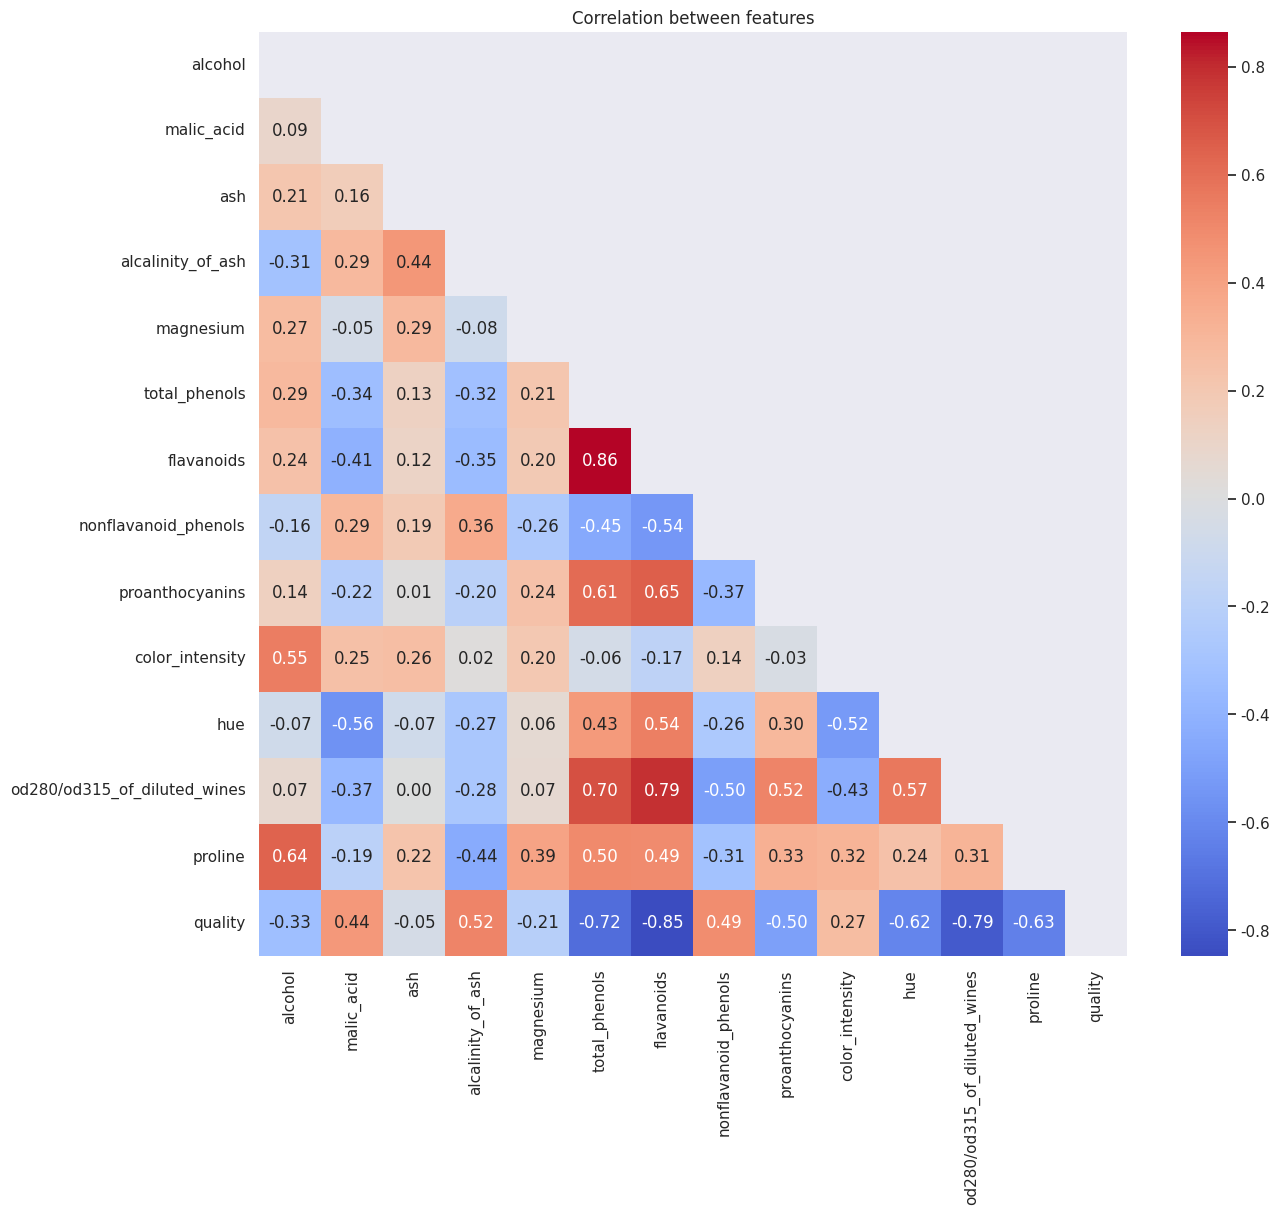

In [53]:
# TODO
# 1. 모든 변수들 사이 상관관계를 `corr`이라는 변수에 담아보세요!
corr = df.corr(numeric_only=True)

# 2. 위에서 만든 `corr`의 shape은 정방형태입니다.
# `corr`을 `sns.heatmap` 위에 그려보세요
# 제가 그린 이미지는 아래 첨부해두었습니다.
"""
요구사항
- 변수가 많습니다. Figure size를 키워주세요
- Heatmap은 한 눈에 상관관계성을 보기에 좋습니다. 하지만 수치적으로 와닿기 위해서 어떤 조치를 취할 수 있을까요?
  - hint: annot=True
- 포맷팅을 소수점 두자리까지만 나오게 해주세요
- colormap은 coolwarm을 사용하고 싶습니다.
  - 참고: https://seaborn.pydata.org/tutorial/color_palettes.html
- 대각행렬에는 자가 상관계수가 들어갑니다. 즉 어차피 1입니다. 제외하고 보여주세요.
- 상관계수 행렬은 대칭행렬입니다. 필요한 경우 전체 행렬을 시각화하기도 하지만, 오늘은 아래 부분만 보고 싶네요. 대각행렬을 기준으로 윗부분 제외하고 아랫부분만 보여주세요.
- 위를 날리고나니 뒤에 있는 grid가 거슬립니다. 없애주세요.
"""

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14,12))
ax = sns.heatmap(
    corr,
    mask=mask, # 하삼각만 표시
    annot=True,# 수치 주석 표시
    fmt='.2f',# 소수점 2자리
    cmap='coolwarm',
    linewidths=0,                             # 내부 그리드 라인 제거
    cbar=True,                                # 컬러바 표시(원하면 False로)
    square=False                              # 필요 시 True로 변경 가능
)
ax.grid(False)
plt.title('Correlation between features')
plt.show()

이렇게 만들어보세요!
![image](https://github.com/1pha/image-repo/blob/main/module3/correlation.png?raw=true)

### 🧑‍💻 **실습**: 분포 살펴보기

도수분포표는 우리가 확인하고자 하는 데이터가 어떤 분포를 가지는지 확인할 수 있습니다. 아래는 가장 기본적인 도수분포표를 그리는 방법입니다.
위에 상관계수를 시각화하는 작업을 다시 살펴봅시다. `quality`와 제일 높은 상관계수를 가지는 변수는 누구인가요? (음의 상관계수가 높은 것 또한 좋은 정보입니다). 이번에는 `flavanoids` 변수의 분포를 확인해봅시다.

⚠️ 주의할 점: 원래대로라면 `quality`는 범주형 변수이기 때문에 알아서 `.corr()` 메소드 수행 중에 제외되어야 합니다. 하지만 우선은 0, 1, 2가 연속형 변수로 들어가있어 상관관계 확인이 가능합니다. 이 점 주의해주세요

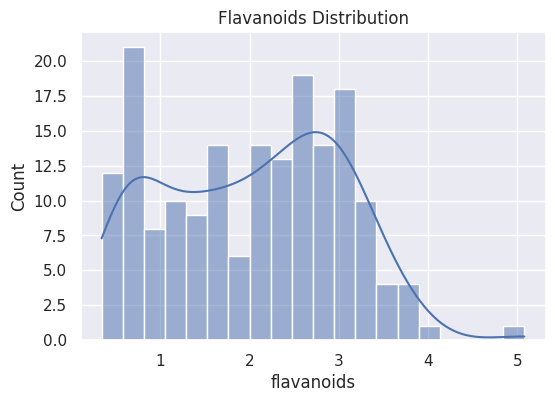

In [54]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='flavanoids', bins=20, kde=True)
plt.title('Flavanoids Distribution')
plt.show()

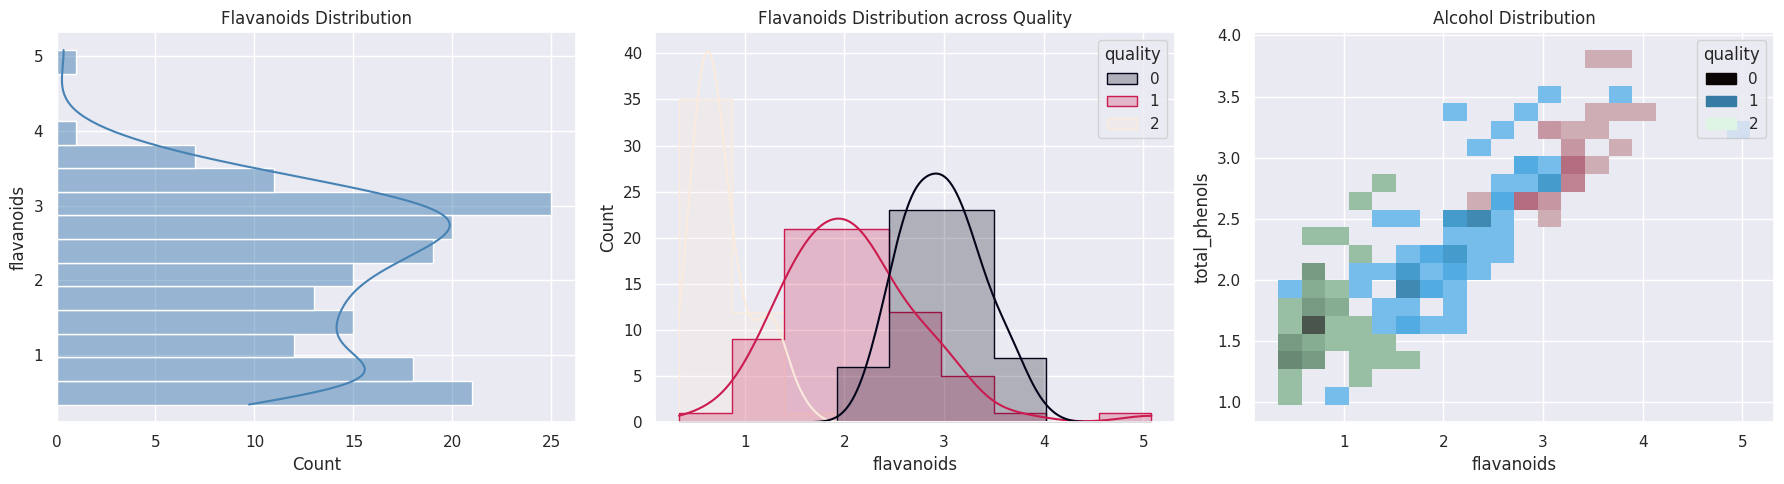

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(18, 5), ncols=3)

# 1️ Flavanoids 전체 분포 (세로형)
sns.histplot(
    data=df,
    y="flavanoids",          # y축으로 세로방향 표시
    bins=15,
    kde=True,                # 밀도곡선 추가
    color="steelblue",
    ax=ax[0]
)
ax[0].set_title("Flavanoids Distribution")

# 2️ 클래스별 Flavanoids 분포
sns.histplot(
    data=df,
    x="flavanoids",
    hue="quality",           # 클래스별 색상 구분
    kde=True,
    element="step",          # 투명 겹침
    palette="rocket",
    ax=ax[1]
)
ax[1].set_title("Flavanoids Distribution across Quality")

# 3️ Flavanoids vs Total Phenols 2D 히스토그램
sns.histplot(
    data=df,
    x="flavanoids",
    y="total_phenols",
    hue="quality",           # 클래스별 색 구분
    bins=20,
    palette="mako",
    ax=ax[2]
)
ax[2].set_title("Alcohol Distribution")

fig.tight_layout()
plt.show()


아래 이미지처럼 만들어보세요
![image](https://github.com/1pha/image-repo/blob/main/module3/histograms.png?raw=true)


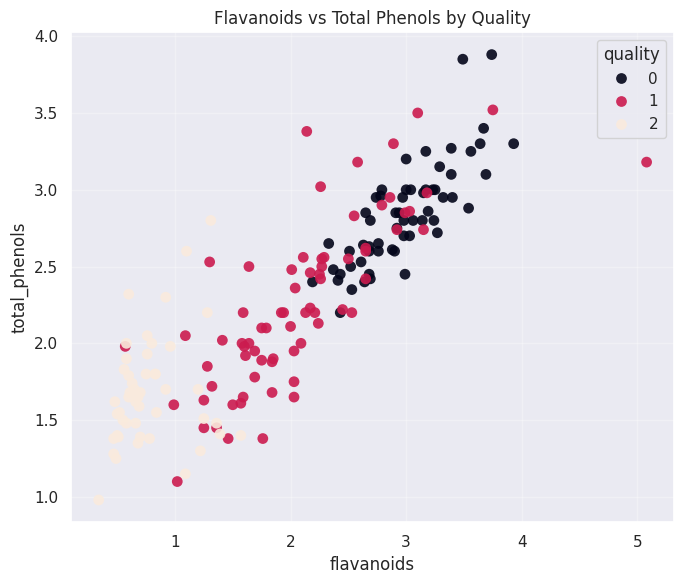

In [56]:
# TODO: scatterplot
# 위에서 ax[2]에서 그린 그림, 유용하긴한데 좀 다르게 살펴보고 싶은데요?
# 같은 변수를 scatterplot을 통해 그려봅시다.
# 아래 제가 첨부해둔 이미지처럼 만들어보세요

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x="flavanoids",
    y="total_phenols",
    hue="quality",            # 품질 등급별 색상 구분
    palette="rocket",         # 예시 이미지와 유사한 컬러맵
    s=60,                     # 점 크기
    edgecolor="none",         # 점 테두리 제거
    alpha=0.9                 # 약간의 투명도
)

plt.title("Flavanoids vs Total Phenols by Quality")
plt.xlabel("flavanoids")
plt.ylabel("total_phenols")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


참고해서 그려보세요   
![image](https://github.com/1pha/image-repo/blob/main/module3/scatterplot.png?raw=true)

상관 높은 특성: ['proline', 'color_intensity', 'quality', 'alcalinity_of_ash']


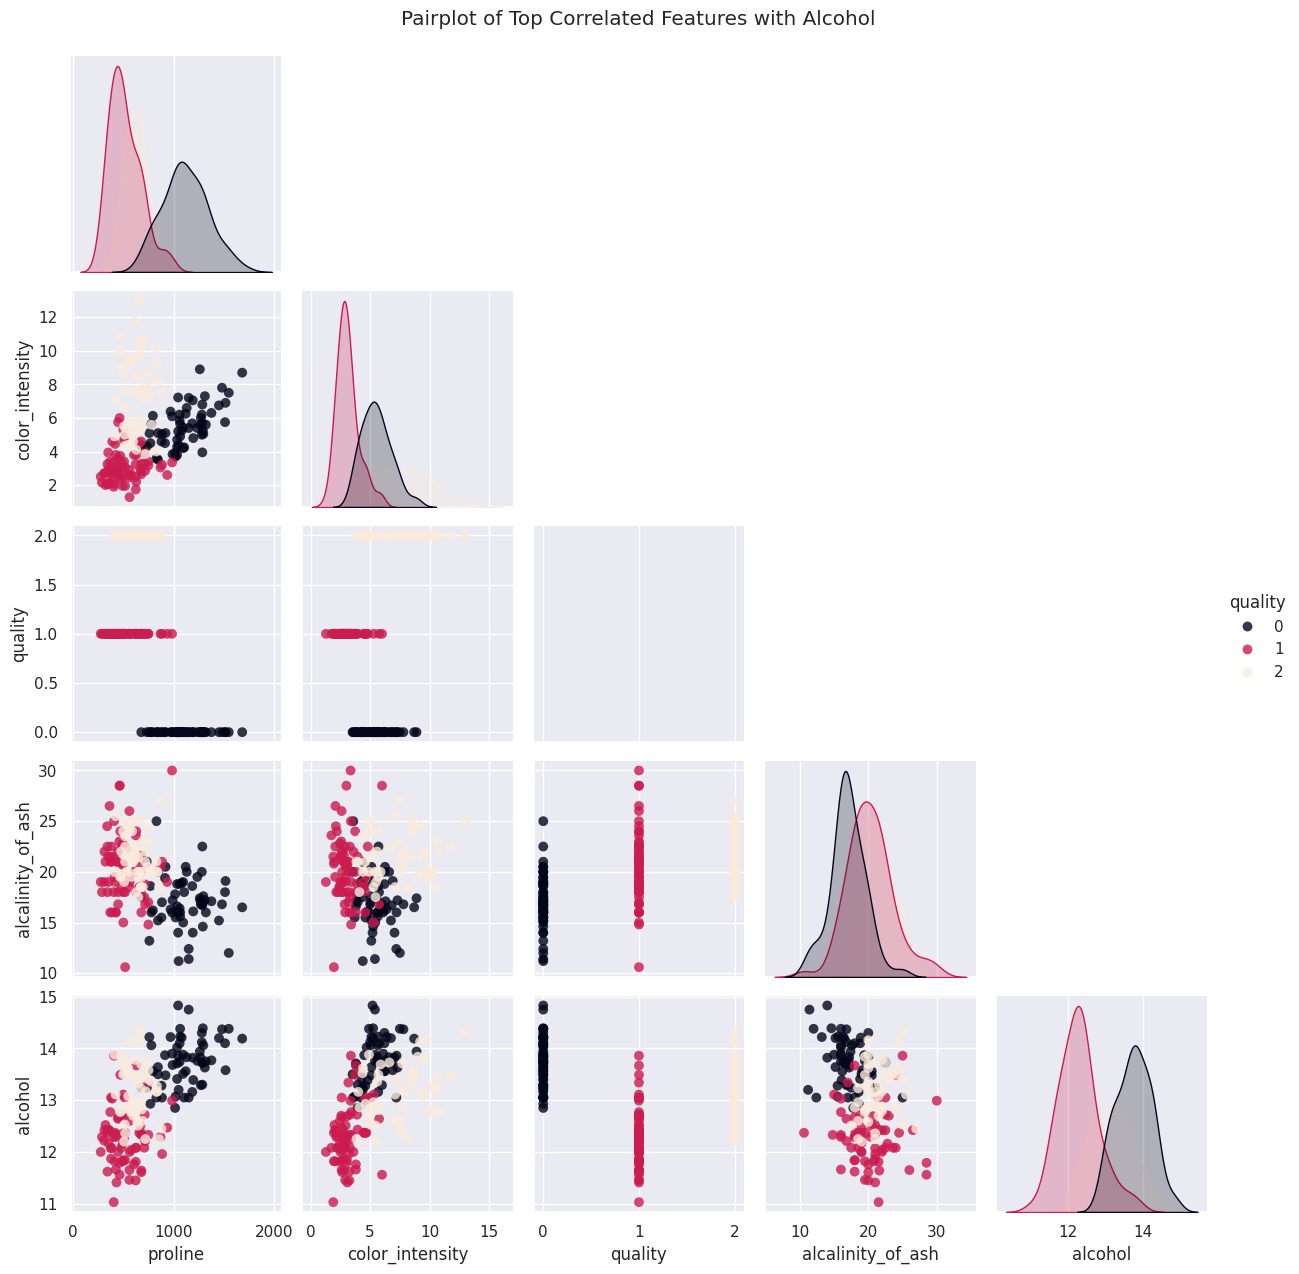

In [57]:
# TODO: pairplot
# 이렇게 살펴보니 `flavanoids`가 quality를 나누는데 굉장히 중요한 key가 될 것 같네요.
# 근데 이렇게 일일히 보니까 귀찮네요. 한 번에 다 그릴 수는 없을까요?
# hint: https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot
# 실제로 모든 feature를 다 그려도 어차피 다 못봅니다. correlation이 높은 feature들을 뽑아서 그려봅시다.




# 2️⃣ Alcohol과 상관이 높은 상위 특성 3~4개 추출
top_corr_features = (
    corr["alcohol"]
    .drop("alcohol")
    .abs()
    .sort_values(ascending=False)
    .head(4)
    .index.tolist()
)
print("상관 높은 특성:", top_corr_features)

# 3️⃣ Pairplot 생성
sns.pairplot(
    data=df,
    vars=top_corr_features + ["alcohol"],   # 알코올과 함께 시각화
    hue="quality",                          # 품질별 색상 구분
    palette="rocket",                       # 와인 느낌 컬러
    diag_kind="kde",                        # 대각선은 KDE로
    corner=True,                            # 하삼각만 표시
    plot_kws={"alpha": 0.8, "s": 50, "edgecolor": "none"}
)
plt.suptitle("Pairplot of Top Correlated Features with Alcohol", y=1.02)
plt.show()


아래 이미지처럼 만들어보세요
![image](https://github.com/1pha/image-repo/blob/main/module3/pairplot.png?raw=true)

좋습니다. 이렇게 데이터를 잘 살펴보았습니다. 데이터간 상관관계를 살펴보는 것도 중요하지만, 데이터에 이상이 있는 것도 우리는 늘 살펴봐야합니다. 데이터가 누락되거나 잘못 기입된 경우가 이에 해당합니다. 실제로 데이터를 처리해보시면 이러한 경우가 비일비재하기 때문에 확인하는 것이 필수적입니다. 표준화된 데이터 분석 방식이 존재하진 않으나, 저의 경우 간단하게 시각화를 살펴보고 이상치가 있거나 분포 사이 관계까 너무 좋거나 나쁜 경우 왜 그런지 데이터를 살펴보는 방향을 선택할 때가 많습니다.

이번에는 데이터에서 누락된 경우가 있는지, 혹은 사용할 수 없는 이상치가 있는지 확인하는 코드와 존재하는 경우 어떻게 대처하면 좋은지 실습을 통해 배워봅시다.

In [58]:
# 결측치 이상치 임의생성
df_missing = df.copy()

# 결측치: flavanoids 컬럼의 일부 값을 NaN으로 변경
np.random.seed(42)
missing_idx = np.random.choice(df_missing.index, size=10, replace=False)
df_missing.loc[missing_idx, 'flavanoids'] = np.nan

# 이상치: alcohol 컬럼의 일부 값을 비정상적으로 크게 설정
outlier_idx = np.random.choice(df_missing.index, size=5, replace=False)
df_missing.loc[outlier_idx, 'alcohol'] = df_missing['alcohol'].mean() * 5

alcohol                          0
malic_acid                       0
ash                              0
alcalinity_of_ash                0
magnesium                        0
total_phenols                    0
flavanoids                      10
nonflavanoid_phenols             0
proanthocyanins                  0
color_intensity                  0
hue                              0
od280/od315_of_diluted_wines     0
proline                          0
quality                          0
dtype: int64


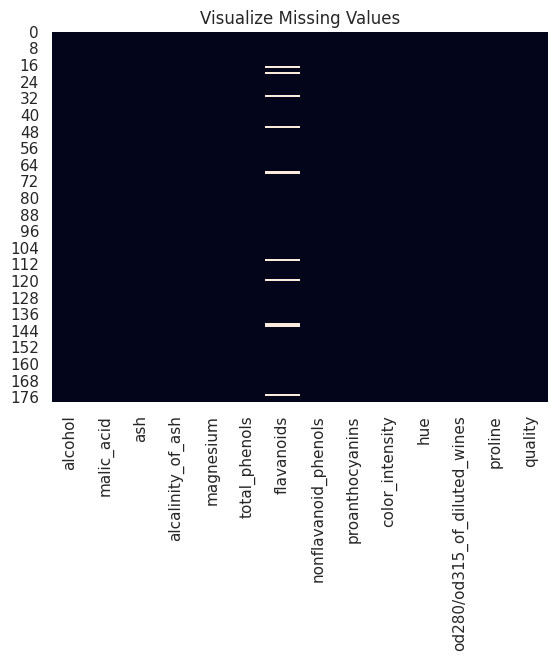

In [59]:
print(df_missing.isnull().sum())

# 시각화로 결측치 확인
sns.heatmap(df_missing.isnull(), cbar=False)
plt.title("Visualize Missing Values")
plt.show()

이상치는 다른 데이터와 비교했을 때 값이 너무 크거나 작아서 눈에 띄는 데이터를 말합니다. 예를 들어 대부분 사람들이 150~190cm 사이의 키를 가지고 있는데, 250cm가 나온다면 이는 이상치일 가능성이 큽니다. 이상치는 데이터 입력 실수, 측정 오류, 혹은 정말 드문 특별한 경우 때문에 발생할 수 있습니다. 분석 전에 이런 값을 확인하고, 잘못된 값이면 제거하거나 경계값으로 바꾸고, 의미가 있다면 그대로 두는 것이 좋습니다.

IQR(사분위 범위)은 이상치를 찾는 대표적인 방법 중 하나입니다. 먼저 데이터를 작은 값부터 큰 값까지 순서대로 정렬하고, 아래쪽 25% 지점(Q1)과 위쪽 25% 지점(Q3)을 찾습니다. IQR은 Q3에서 Q1을 뺀 값으로, 데이터의 중간 50% 범위를 의미합니다. 이상치는 보통 Q1보다 1.5 × IQR만큼 작거나, Q3보다 1.5 × IQR만큼 큰 값으로 정의합니다. 이 방법은 평균과 표준편차를 쓰는 방법보다 극단값에 덜 민감하고, 데이터가 정규분포를 따르지 않아도 사용할 수 있다는 장점이 있습니다.

alcohol 이상치 개수: 5


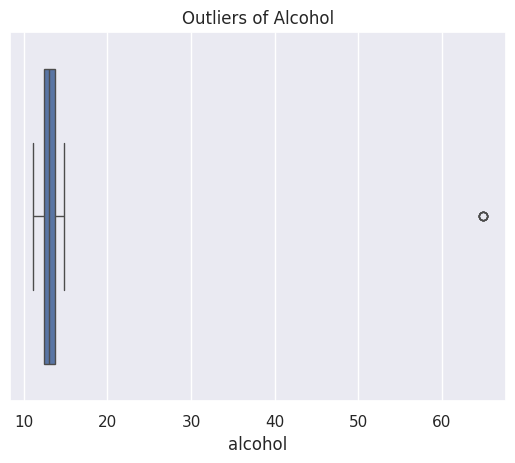

In [60]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers_alcohol = detect_outliers_iqr(df_missing, 'alcohol')
print(f"alcohol 이상치 개수: {len(outliers_alcohol)}")

# boxplot으로 이상치 확인
sns.boxplot(x=df_missing['alcohol'])
plt.title("Outliers of Alcohol")
plt.show()

결측치(Missing Value)와 이상치(Outlier)는 데이터 분석에서 반드시 먼저 확인하고 처리해야 하는 부분입니다. 결측치는 데이터가 비어 있는 경우를 말하며, 처리 방법에는 크게 두 가지가 있습니다. 첫째, 결측치가 있는 행이나 열을 통째로 삭제하는 방법이 있습니다. 데이터가 충분히 많고 결측이 일부일 때는 유용하지만, 데이터 손실이 클 수 있습니다. 둘째, 결측 값을 다른 값으로 채우는 방법이 있습니다. 숫자형 데이터의 경우 평균값, 중앙값, 최빈값으로 채우거나, 시계열 데이터에서는 이전 값이나 다음 값으로 채우는 방법을 씁니다. 더 나아가 머신러닝 모델로 결측치를 예측해 채우는 고급 기법도 있습니다.

이상치는 다른 데이터와 비교했을 때 지나치게 크거나 작은 값으로, 데이터 입력 오류, 측정 실수, 혹은 드문 현상 때문에 발생할 수 있습니다. 이상치 처리 방법 역시 크게 세 가지입니다. 첫째, 명백히 잘못된 값이면 해당 데이터를 삭제합니다. 둘째, 로그 변환이나 제곱근 변환 등을 통해 데이터 분포를 조정합니다. 셋째, 이상치를 상한·하한 경계값으로 바꾸거나 평균·중앙값으로 대체합니다.

무엇보다 중요한 점은, 결측치나 이상치를 무조건 제거하거나 바꾸기 전에 왜 생겼는지를 먼저 확인하는 것입니다. 실측 오류라면 제거하는 것이 맞지만, 의미 있는 값이라면 보존하거나 변환하는 것이 더 적절합니다. 그리고 때로는 결측 그 자체가 데이터 분석에서 중요한 특징이 될 수도 있습니다.

In [61]:
# 결측치: 평균값으로 대체
df_filled = df_missing.fillna(df_missing.mean(numeric_only=True))
assert df_filled['flavanoids'].isnull().sum() == 0, "❌ flavanoids 컬럼에 결측치가 남아 있습니다."

# 이상치: IQR 기준 밖의 값 제거
df_no_outliers = df_filled[~df_filled.index.isin(outliers_alcohol.index)]

# Test code 입니다. 수정없이 사용해주세요.
from scipy.stats import iqr
Q1 = df_filled['alcohol'].quantile(0.25)
Q3 = df_filled['alcohol'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치가 제거된 상태인지 확인
outliers_remaining = df_no_outliers[(df_no_outliers['alcohol'] < lower_bound) | (df_no_outliers['alcohol'] > upper_bound)]
assert len(outliers_remaining) == 0, f"❌ alcohol 컬럼에 이상치가 {len(outliers_remaining)}개 남아 있습니다."

print(f"처리 전 데이터 크기: {df_missing.shape}")
print(f"이상치 제거 후 데이터 크기: {df_no_outliers.shape}")
print("✅ 모든 테스트를 통과했습니다!")

처리 전 데이터 크기: (178, 14)
이상치 제거 후 데이터 크기: (173, 14)
✅ 모든 테스트를 통과했습니다!


# 2. 머신러닝 전처리 및 모델 학습·검증, 차원축소 & 군집화

**학습 목표**
  - 학습용과 평가용 데이터셋으로 분리
  - 특성 값 정규화로 학습 안정성 확보
  - 분류 모델 학습 및 예측 수행
  - 분류 성능 지표로 모델 평가
  - 교차검증으로 일반화 성능 검증
  - 차원 축소와 군집 분석으로 데이터 패턴 탐색

**학습 개념**
  - `train_test_split` : 데이터를 학습용/평가용으로 분할하며, stratify 파라미터로 레이블 분포를 유지
  - `StandardScaler` : 특성별 평균을 0, 분산을 1로 변환해 모델 학습 안정성 및 최적화 속도 향상
  - `LogisticRegression` : 선형 결정 경계를 기반으로 확률 예측 및 해석이 가능한 지도학습 분류 알고리즘
  - `confusion_matrix` & `classification_report` : 정밀도, 재현율, F1-score 등을 한눈에 보여주는 분류 성능 요약 지표
  - `roc_curve` & `roc_auc_score` : 이진 분류 성능을 FPR-TPR 곡선 및 AUC 값으로 평가
  - `cross_val_score` : 데이터를 여러 폴드로 나누어 반복 학습·평가함으로써 모델의 일반화 성능을 안정적으로 추정
  - `PCA` : 고차원 데이터를 주성분 축으로 투영해 정보 손실을 최소화하며 저차원으로 압축
  - `KMeans` : 중심 기반 군집화 알고리즘으로, 미리 정한 클러스터 수만큼 그룹을 형성

**진행하는 실습 요약**
   - `train_test_split`로 데이터 분할
   - `StandardScaler().fit(X_train)` → `transform(X_train)`, `transform(X_test)`로 스케일링 적용
   - `LogisticRegression()` 객체 생성 후 `.fit(X_train, y_train)` → `.predict(X_test)`로 예측
   - `confusion_matrix`, `classification_report`로 오차행렬·정밀도·재현율·F1 출력
   - `predict_proba` 또는 decision_function을 통해 FPR·TPR를 계산하고 `roc_curve`, `roc_auc_score`로 ROC-AUC 시각화
   - `cross_val_score`로 5-fold CV 수행, 평균 F1-score 확인
   - `PCA`로 2차원 임베딩 `X_pca` 생성
   - `KMeans`로 군집 레이블 추론

좋습니다. 현재까지 데이터를 살펴보고 이상치/결측치가 존재하는 경우 어떻게 처리하면 되는지에 대해 배워보았습니다. 아직까지 모델링을 진행하지 않은 사실, 깨달으셨나요?

우리가 지난 번에 작성한 수많은 코드들을 다시 작성할 필요는 없습니다. 왜나하면 이 모든 일들을 미리 수행해둔 `scikit-learn`이 있기 때문이죠. `scikit-learn`은 데이터의 전처리와 간단한 머신러닝 모듈들을 빠르게 구현할 수 있도록 도와주는 라이브러리입니다. 대부분의 모듈은 다음과 같은 파이프라인으로 구동됩니다.

1. Instance 선언
2. `.fit()`을 통한 매개변수 학습 혹은 초매개변수 설정
3. 2.에서 최적화한 매개변수들을 이용해 `.predict()`를 통한 모델 예측, 혹은 설정된 초매개변수를 통한 `.transform()` 수행

간단하게 전처리를 수행해볼까요?

### 🧑‍💻 **실습**: `sklearn`을 통한 데이터 전처리

강의와 챕터0에서 우리는 전체 데이터를 학습에 사용하는 것이 아닌 일부 데이터만을 사용하여 처음 보는 데이터에 대한 모델의 성능을 확인하는 것이 중요하다는 점을 배웠습니다. 따라서 데이터를 `train`용과 `test`용으로 나눠보는 것으로 시작해봅시다.

그리고 `train` 데이터에 대해 데이터 표준화를 진행하고, 여기에 사용된 평균/표준편차를 통해 `test` 데이터 또한 표준화하는 과정을 거칩니다.


In [62]:
# TODO
X = df.drop('quality', axis=1).values
y = df['quality'].values
y[y == 0] = 0
y[y != 0] = 1

# 1. Train/test 데이터를 나눠봅시다.
# X, y는 제가 나누어두었습니다. 우리는 이진과제를 수행할 예정이라 class 1, 2를 합쳐서 1로 두었습니다.
""" 요구사항
- test data는 전체 데이터 중 30%를 차지하게 해주세요.
- `train_test_split`은 기본적으로 난수를 사용하기 때문에 함수를 호출할 때마다 다른 결과가 나옵니다.
  함수의 결과를 고정시켜주세요. (hint: random_state)
- 가끔 운이 나쁜 날에 y_train에는 전부 0이, y_test에는 전부 1이 들어갈 수 있습니다.
  이를 방지할 수 있을까요? (hint: stratify)
HINT: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,     # 결과 고정
    stratify=y           # 클래스 비율 유지
)

# 2. 표준화를 진행합시다.
# 직접 평균/표준편차를 구하는 것이 아니라 `sklearn.preprocessing.StandardScaler`를 사용합시다.
# X_train과 X_test를 표준화한 X_train_norm과 X_test_norm을 만들어주세요.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm =  scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# 3. 비교해보세요!
scaler.mean_, X_train.mean(axis=0), X_test.mean(axis=0)

(array([1.29707258e+01, 2.34491935e+00, 2.36129032e+00, 1.95556452e+01,
        9.97822581e+01, 2.29000000e+00, 1.99846774e+00, 3.63467742e-01,
        1.61733871e+00, 5.03814515e+00, 9.56258065e-01, 2.58524194e+00,
        7.46467742e+02]),
 array([1.29707258e+01, 2.34491935e+00, 2.36129032e+00, 1.95556452e+01,
        9.97822581e+01, 2.29000000e+00, 1.99846774e+00, 3.63467742e-01,
        1.61733871e+00, 5.03814515e+00, 9.56258065e-01, 2.58524194e+00,
        7.46467742e+02]),
 array([1.30692593e+01, 2.31666667e+00, 2.37851852e+00, 1.93555556e+01,
        9.96481481e+01, 2.30685185e+00, 2.10000000e+00, 3.58148148e-01,
        1.53018519e+00, 5.10388889e+00, 9.60185185e-01, 2.67240741e+00,
        7.47870370e+02]))

### 🧑‍💻 **실습**: `sklearn`을 통한 모델 훈련 및 검증
좋습니다. 성공적으로 train/test 데이터를 나누고 전처리까지 수행하였습니다. 이제는 모델링을 진행해봅시다. 아까 설명한 `sklearn` 모듈들의 파이프라인을 숙지하면 됩니다. API Reference를 잘 살펴보면 좋습니다.
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

[[18  0]
 [ 2 34]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.94      0.97        36

    accuracy                           0.96        54
   macro avg       0.95      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



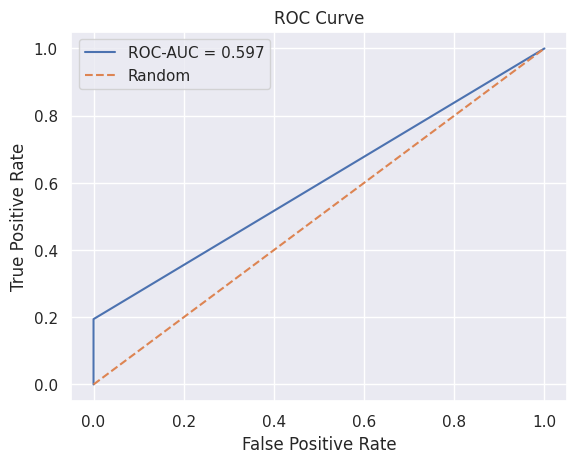

In [63]:
# TODO
# 1. 모델을 선언해서 `clf`에 할당해주세요.
from sklearn.linear_model import LogisticRegression
clf =  LogisticRegression(max_iter=1000,class_weight='balanced',  random_state=42)


# 2. `.fit`을 통해 모델을 학습시켜주세요
# ❓ 혹시 `ConvergenceWarning`이 떴나요? 해당 경고는 왜 등장하며 어떻게 처리하면 좋을까요?
# https://www.slingacademy.com/article/understanding-scikit-learns-convergencewarning-and-how-to-resolve-it/
clf.fit(X_train_norm, y_train)

# 3. `X_test`를 예측해서 `y_pred`에 할당해주세요
y_pred = clf.predict(X_test_norm)

# 4. 이진분류 과제를 여러 가지 평가지표로 평가해봅시다.
# https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 아래는 ROC-AUC를 그리는 방법입니다. 한 번 살펴보고 결과가 잘 나오는지 확인해보세요
# 참고: https://m.blog.naver.com/koys007/222540017715
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 양성(1) 클래스의 "점수" 얻기: 가능하면 확률, 없으면 decision_function 점수
y_score = clf.predict_proba(X_test)[:, 1]

# FPR, TPR, 임계값과 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

# ROC 곡선 시각화 (matplotlib 사용)
plt.plot(fpr, tpr, label=f'ROC-AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

### 🧑‍💻 **실습**: `sklearn`을 통한 교차 검증 (Cross-Validation)
교차검증(Cross-Validation)은 모델의 성능을 더 신뢰성 있게 평가하기 위해 데이터를 여러 번 나누어 학습과 검증을 반복하는 방법입니다. 단순히 한 번의 train/test 분할만으로 성능을 측정하면, 우연히 데이터가 편향되어 들어가서 평가 결과가 과대 또는 과소 추정될 수 있습니다. 교차 검증은은 데이터를 여러 개의 폴드(fold)로 나눈 뒤, 각 폴드가 한 번씩 검증 데이터가 되도록 순환하며 학습과 평가를 진행합니다. 이렇게 얻은 여러 번의 점수를 평균하면, 데이터 분할에 따른 편차를 줄이고 모델의 일반화 성능을 더 안정적으로 추정할 수 있습니다.

In [66]:
from sklearn.model_selection import cross_val_score

# TODO: 5-fold 교차검증 진행하기
# 5-fold 교차검증 진행
# 현재 선택한 초매개변수가 데이터 분할에 따라 편향되지 않고,
# 안정적으로 일반화 성능을 내는지 확인하는 과정입니다.
# 각 fold마다 모델을 새로 학습(fit) 후 검증 데이터를 평가하며,
# 최종적으로 평균 F1-score를 산출합니다.
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

f1_scores = cross_val_score(pipe, X, y, cv=5, scoring="f1")
print("Average F1-score (CV):", f1_scores.mean())

print("Average F1-score (CV):", f1_scores.mean())

Average F1-score (CV): 0.9870490286771506
Average F1-score (CV): 0.9870490286771506


### 🧑‍💻 **실습**: `sklearn`을 통한 PCA 분석
PCA(주성분 분석)는 데이터의 차원을 줄여서 주요한 패턴을 두세 개의 축으로 표현해 주는 기법입니다. 이렇게 하면 고차원 데이터라도 2차원이나 3차원에서 쉽게 시각화할 수 있어, 데이터의 분포나 구조를 직관적으로 파악할 수 있습니다.

KMeans는 비지도 학습 기반의 군집화 알고리즘으로, 데이터들을 유사한 특성을 가진 그룹(클러스터)으로 나눕니다. PCA로 축소한 데이터를 KMeans에 적용하면, 데이터가 어떤 기준으로 묶이는지 시각적으로 쉽게 확인할 수 있습니다.

즉, 이 코드는 고차원 데이터를 이해하기 쉽게 줄이고(PCA), 그 안에서 자연스럽게 형성되는 그룹을 찾아내어(KMeans) 시각적으로 표현하기 위해 필요합니다. 이를 통해 데이터의 숨겨진 패턴이나 구조를 발견할 수 있고, 이후 분석 방향을 세우는 데 큰 도움을 줍니다.

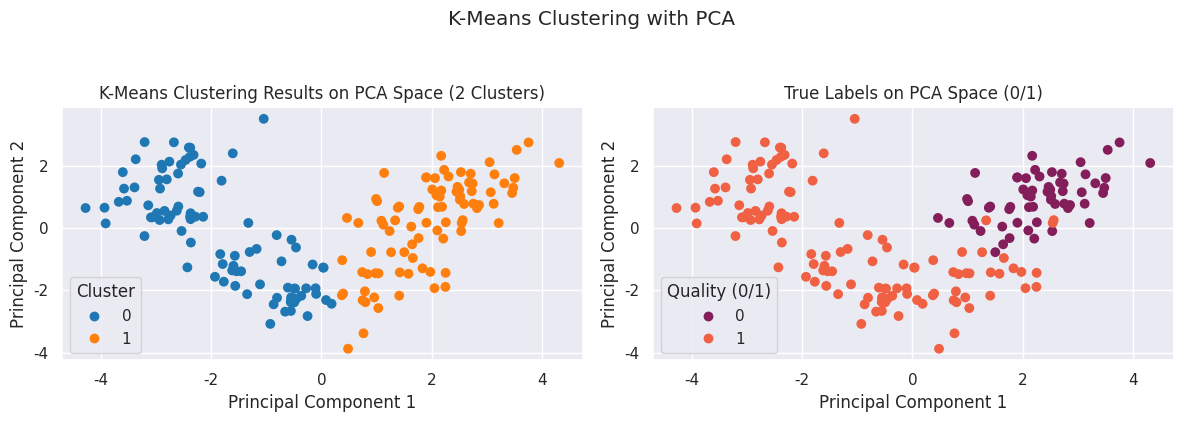

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) Standardization
X_std = StandardScaler().fit_transform(X)

# 2) PCA (2D dimensionality reduction)
pca = PCA(n_components=2, random_state=42)
X_pca: np.ndarray = pca.fit_transform(X_std)  # (n_samples, 2)

# 3) K-Means clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# 4) Visualization
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

# (Left) K-Means predicted clusters
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=clusters, palette="tab10", s=50, edgecolor="none", ax=ax[0]
)
ax[0].set_title("K-Means Clustering Results on PCA Space (2 Clusters)")
ax[0].set_xlabel("Principal Component 1")
ax[0].set_ylabel("Principal Component 2")
ax[0].legend(title="Cluster", loc="best")

# (Right) True labels
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=y, palette="rocket", s=50, edgecolor="none", ax=ax[1]
)
ax[1].set_title("True Labels on PCA Space (0/1)")
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2")
ax[1].legend(title="Quality (0/1)", loc="best")

fig.suptitle("K-Means Clustering with PCA", y=1.05)
fig.tight_layout()
plt.show()


아래 이미지처럼 만들어보세요
![image](https://github.com/1pha/image-repo/blob/main/module3/pca.png?raw=true)

# 마치며...

오늘은 `wine` 데이터를 본격적으로 데이터 분석가처럼 분석하여 분륚과제까지 잘 수행하였습니다. 과제에서는 다른 회귀 과제를 수행할 수 있는 데이터를 통해 EDA와 모델링을 진행해봅시다. 수고 많으셨습니다!